In [4]:
# Import necessary libraries for image processing, machine learning, and visualization.
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# TensorFlow/Keras imports for deep learning model creation and training.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [5]:
# Set a fixed random seed to ensure reproducible results.
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configuration and constants
IMAGE_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 5
CLASS_LABELS = ['pituitary', 'glioma', 'notumor', 'meningioma']


In [6]:
# Directories for training and testing data
train_dir = 'Training'
test_dir = 'Testing'

In [7]:
# Function to load image paths and labels from given directory.
def load_data(directory):
    paths = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                if os.path.isfile(image_path) and image.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                    paths.append(image_path)
                    labels.append(label)
    return shuffle(paths, labels, random_state=42)


In [8]:
# Load train and test data
print("Loading training and testing data...")
train_paths, train_labels = load_data(train_dir)
test_paths, test_labels = load_data(test_dir)

print(f"Training samples: {len(train_paths)}")
print(f"Testing samples: {len(test_paths)}")

Loading training and testing data...
Training samples: 5580
Testing samples: 1311



Combined Training and Test DataSet Distribution:


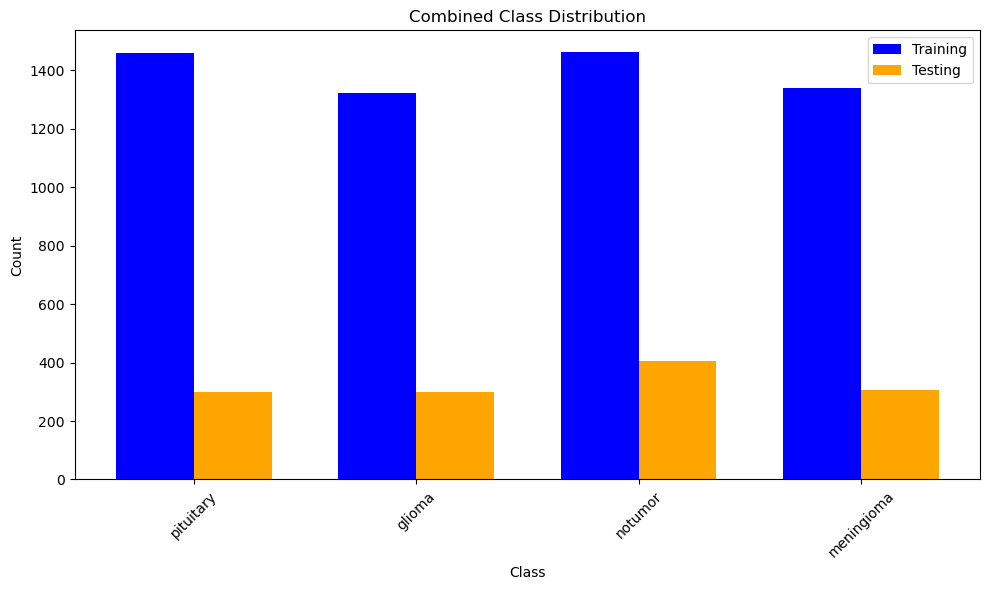

Training DataSet Distribution:
pituitary: 1457 (26.11%)
glioma: 1321 (23.67%)
notumor: 1463 (26.22%)
meningioma: 1339 (24.00%)

Testing DataSet Distribution:
pituitary: 300 (22.88%)
glioma: 300 (22.88%)
notumor: 405 (30.89%)
meningioma: 306 (23.34%)


In [9]:
# Combined Class Distribution Plot for Training and Testing Sets
def show_combined_distribution(train_labels, test_labels, title="Combined Class Distribution"):
    # Ensure using the globally defined CLASS_LABELS for ordering consistency
    labels = CLASS_LABELS
    
    # Count the occurrences in training and testing sets
    train_counts = [np.sum(np.array(train_labels) == label) for label in labels]
    test_counts = [np.sum(np.array(test_labels) == label) for label in labels]
    
    x = np.arange(len(labels))  # Label locations
    width = 0.35  # Width for each bar group
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, train_counts, width, label='Training', color='blue')
    plt.bar(x + width/2, test_counts, width, label='Testing', color='orange')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Training and Test DataSet Distribution.pdf")
    plt.show()
    
    # Optionally, print out the percentages for each class
    total_train = sum(train_counts)
    total_test = sum(test_counts)
    print("Training DataSet Distribution:")
    for label, count in zip(labels, train_counts):
        print(f"{label}: {count} ({count/total_train*100:.2f}%)")
    print("\nTesting DataSet Distribution:")
    for label, count in zip(labels, test_counts):
        print(f"{label}: {count} ({count/total_test*100:.2f}%)")

# Insert the following after the code that displays sample training images, for example:
print("\nCombined Training and Test DataSet Distribution:")
show_combined_distribution(train_labels, test_labels)

In [10]:
# Display some sample images
def display_samples(paths, labels, num_samples=10):
    random_indices = random.sample(range(len(paths)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()

    for i, idx in enumerate(random_indices):
        img_path = paths[idx]
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Resize for display
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[idx]}", fontsize=10)

    plt.tight_layout()
    plt.show()

Displaying sample training images...


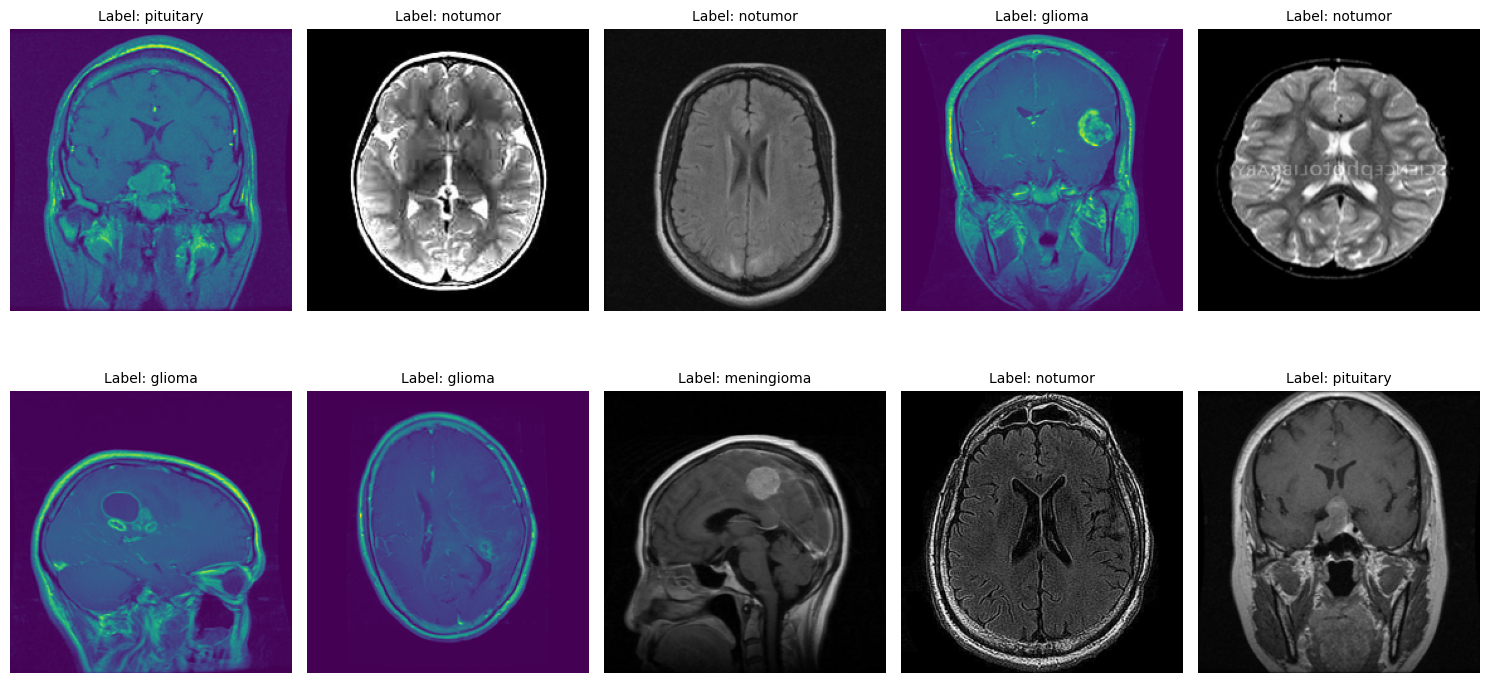

In [11]:
# Display sample training images
print("Displaying sample training images...")
display_samples(train_paths, train_labels)


In [12]:
# Define a simple image augmentation function.
def augment_image(image, augment=True):
    if augment:
        image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
        image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    
    # Return normalized image
    return np.array(image) / 255.0

In [13]:
#Load images and apply augmentation(Load and process images.)
def open_images(paths, augment=True):
    images = [] #preprocessed(augmented) image list
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image, augment)
        images.append(image) #preprocessed(augmented) image list
    return np.array(images) #pixel value array



In [14]:
# Encoding labels (convert label names to integers)
def encode_label(labels):
    encoded = [CLASS_LABELS.index(label) for label in labels]
    return np.array(encoded)


In [15]:
# Data generators for training.(repeats indefinitely)
def datagen(paths, labels, batch_size=BATCH_SIZE):
    while True:  # Added to repeat the generator
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = encode_label(labels[i:i + batch_size])
            yield batch_images, batch_labels


In [16]:
# # Data Generator for validation.(repeats indefinitely)
def datagen_val(paths, labels, batch_size=BATCH_SIZE): #testing data for validation
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths, augment=False)
            batch_labels = encode_label(labels[i:i + batch_size])
            yield batch_images, batch_labels

In [17]:
# Build the model
def build_model():
    # Create base model from VGG16
    base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    
    # Freeze all layers of the VGG16 base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Set the last few layers of the VGG16 base model to be trainable
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True
    
    # Build the final model
    model = Sequential()
    model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(CLASS_LABELS), activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy'])
    
    return model

In [18]:
# Create and train the model
print("Building and training the model...")
model = build_model()
steps = int(len(train_paths) / BATCH_SIZE)


Building and training the model...


In [19]:
# Model is trained on the training data and then evaluated on the test data.
train_steps = int(len(train_paths) / BATCH_SIZE)
val_steps = int(len(test_paths) / BATCH_SIZE)
history = model.fit(
    datagen(train_paths, train_labels, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=datagen_val(test_paths, test_labels, batch_size=BATCH_SIZE),
    validation_steps=val_steps
)

Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 0.6547 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.5187 - val_sparse_categorical_accuracy: 0.8038
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - loss: 0.2666 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.2376 - val_sparse_categorical_accuracy: 0.8992
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - loss: 0.1708 - sparse_categorical_accuracy: 0.9378 - val_loss: 0.2897 - val_sparse_categorical_accuracy: 0.9055
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - loss: 0.1153 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.2146 - val_sparse_categorical_accuracy: 0.9295
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.1026 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.2140 - val_sparse_categorical_accuracy: 0.9349


In [20]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,021,198 (122.15 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 16,257,290 (62.02 MB)

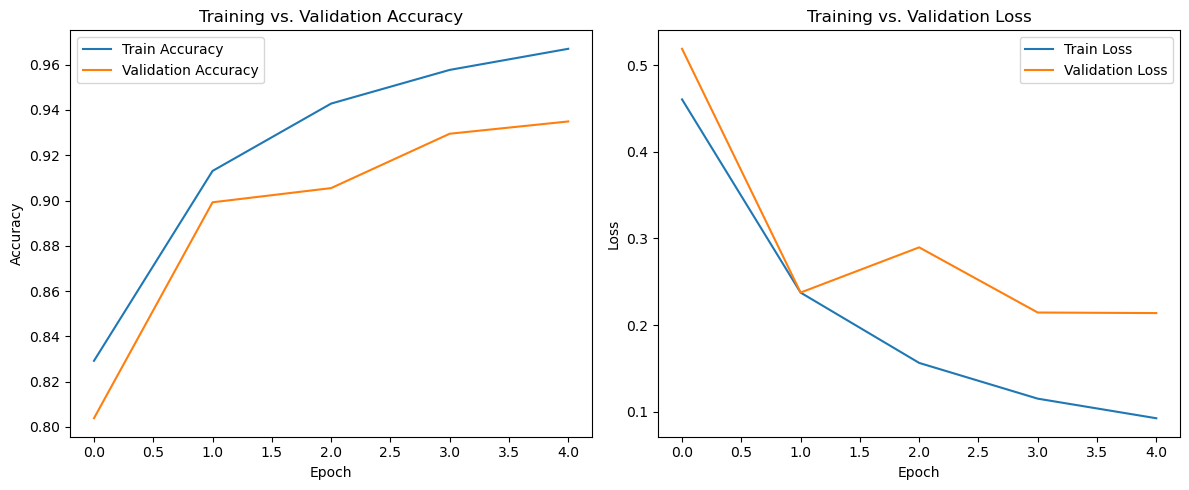

In [21]:
# Plot Training vs. Validation Accuracy/Loss curves
plt.figure(figsize=(12, 5))

# Plot Training vs. Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_vs_validation_curves.pdf")
plt.show()


In [22]:
# Evaluate model performance
print("Evaluating model performance...")
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)
test_predictions = model.predict(test_images)

Evaluating model performance...
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [23]:
# Classification report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       300
           1       0.98      0.89      0.93       300
           2       0.93      1.00      0.96       405
           3       0.83      0.95      0.88       306

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[255   3   9  33]
 [  0 267   6  27]
 [  0   1 403   1]
 [  0   1  15 290]]


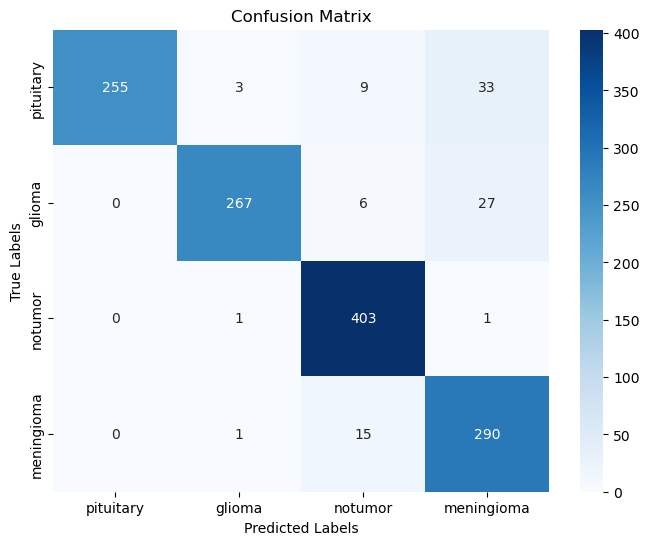

In [25]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix.pdf")
plt.show()


In [26]:
# ROC Curve and AUC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(CLASS_LABELS)))
test_predictions_bin = test_predictions


In [27]:
# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


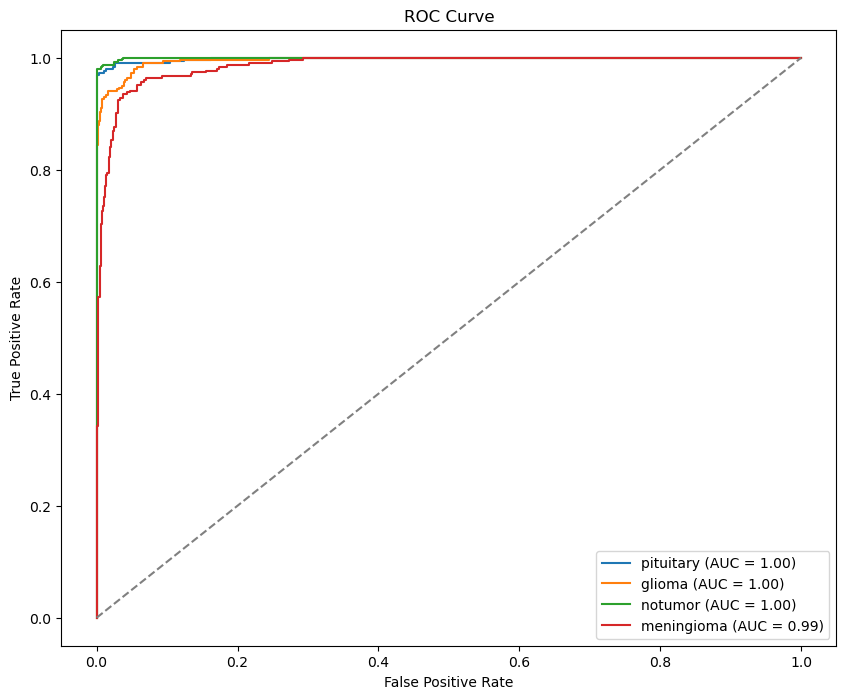

In [28]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(CLASS_LABELS)):
    plt.plot(fpr[i], tpr[i], label=f'{CLASS_LABELS[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("roc_curve.pdf")
plt.show()


In [29]:
# Test with example images
def detect_and_display(img_path, model):
    """
    Function to detect tumor and display results.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        # img = augment_image(img)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        result = "No Tumor" if CLASS_LABELS[predicted_class_index] == 'notumor' else f"Tumor: {CLASS_LABELS[predicted_class_index]}"

        # Display the image with the prediction
        plt.figure(figsize=(8, 6))
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()
        
        return result, confidence_score

    except Exception as e:
        print("Error processing the image:", str(e))
        return None, None

In [30]:
#Example test images 
test_image_paths = [
    os.path.join(test_dir, 'meningioma', 'Te-meTr_0001.jpg'),  # Meningioma
    os.path.join(test_dir, 'notumor', 'Te-noTr_0004.jpg'),     # No tumor
    os.path.join(test_dir, 'pituitary', 'Te-piTr_0003.jpg'),   # Pituitary
    os.path.join(test_dir, 'glioma', 'Te-gl_0015.jpg')         # Glioma
]

Testing example images...

Testing image: Testing/meningioma/Te-meTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


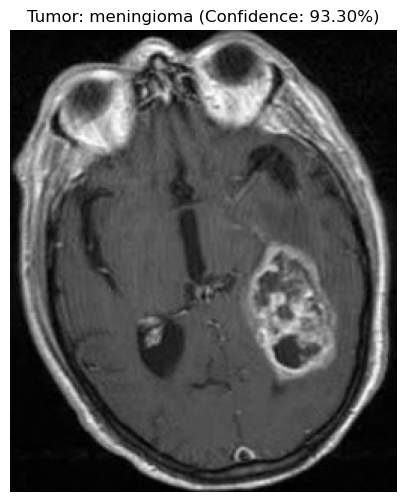

Result: Tumor: meningioma, Confidence: 93.30%

Testing image: Testing/notumor/Te-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


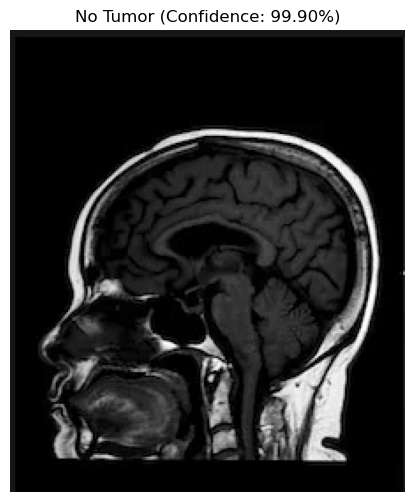

Result: No Tumor, Confidence: 99.90%

Testing image: Testing/pituitary/Te-piTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


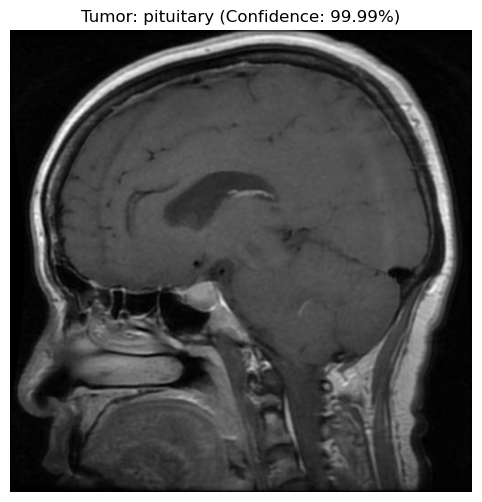

Result: Tumor: pituitary, Confidence: 99.99%

Testing image: Testing/glioma/Te-gl_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


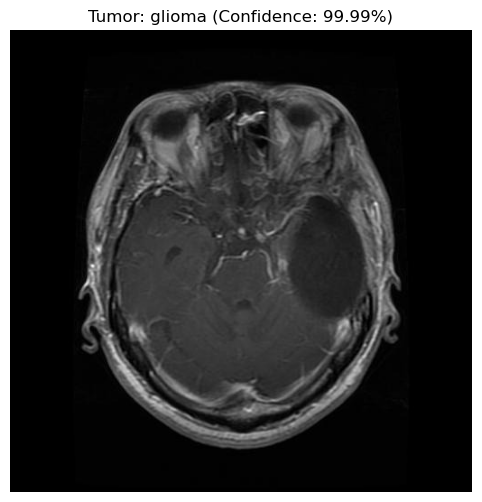

Result: Tumor: glioma, Confidence: 99.99%


In [31]:
# Test each image
print("Testing example images...")
for path in test_image_paths:
    if os.path.exists(path):
        print(f"\nTesting image: {path}")
        result, confidence = detect_and_display(path, model)
        if result:
            print(f"Result: {result}, Confidence: {confidence*100:.2f}%")
    else:
        print(f"Image not found: {path}")


In [32]:
# # Save the model
# model_save_path = 'models/model.h5'
# os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
# model.save(model_save_path)
# print(f"Model saved to {model_save_path}")

# # Save the model
# model_save_path = 'models/model_weights.h5'
# os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
# model.save_weights(model_save_path)
# print(f"Model weights saved to {model_save_path}")

# Save the model
# CORRECTED FILENAME
model_save_path = 'models/model.weights.h5' 
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save_weights(model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to models/model.weights.h5
